Author: Tony Yum

[GitHub](https://github.com/jiujitsu-sekai/kinyu-demos)
[Linkedin](https://www.linkedin.com/in/tonyyum/)

# Overridable Dependency Graph

In this demo I would like to show the concept of a overridable dependency graph and a very simple implementation to demonstrate it.

## Why?

In finance/banking one of the most common questions asked is "what is my risk". One way to define risk is what if I change a risk factor in the market, what would the impact of my portfolio be.

In essence we want to override a piece of market data and re-price a portfolio. This would mean every function/node in the tree that represent your calculation would need to be executed again for each senario. Think about this.

* We bumped the FX Spot. Do we really need to rebuild all relevent curves for a swap?
* We bumped the Eq technology index, do we need to reprice all our exotic FX Options?

In many banks, these questions are effeciently answered with a dependency graph. i.e. if you overrode the value of a node, only ancesters of that node would need to be revaluated. This is the graph that would be demonstrated here.

As a bonus, calculation on graph is much easier to visualise and understand and we will see that later.

## What it isn't

There are all sort of varied and wonderful graph libraries in python. 

Although the concept of the graph in this writing can be adapted to work with those (I could write about them another time), it aims to show a different idea.

Below are some honourable mentions.

* tensor static graph. This allows python code to configure what calculation is needed and when we say "go" CPU and GPU runs highly optimised machine code without going near python making it great for tensor calculations and of course applied in ML.
* pipdeptree: pip package dependency
* pycallgraph. Call graph.
* dask graph. Used for scheduling distributed compute tasks.


## The Demo

Below shows how a very basic graph system can be implemented by leveraging pythong ast library and decorators.

Graphviz would be used to display the graph

## Imports

In [1]:
import ast
import inspect
import time
import itertools
from frozendict import frozendict
from IPython.display import display
import graphviz
import inspect
from collections import namedtuple
from typing import Dict, List
from matplotlib import pyplot as plt
%matplotlib inline

## Defining a few function

Let us define a few functions. As we can there is a tree of dependency here.

* a -> b, c
* c -> d

In [2]:
def a():
    return b() + c()

def b():
    return 2

  
def c():
    return d() + 1

def d():
    return 5

funcs = 'abcd'

## Parse the dependency tree

Python is a dynamic laugage that let's us easily see the source of a function, parse source into an AST
and gives us the tools to inspect and manipuate that tree.

Let's take a look at function *a* and see what it depends on.

In [3]:
class Parser(ast.NodeVisitor):
    def __init__(self):
        self.dependency = []

    def generic_visit(self, node):        
        if type(node).__name__ == 'Call':            
            self.dependency.append(node.func.id)            
        ast.NodeVisitor.generic_visit(self, node)
        
p = Parser()
p.visit(ast.parse(inspect.getsource(a)))
p.dependency

['b', 'c']

Okay. That was easy. Now let's get the dependencies of all the functions we're interested in

In [4]:
GraphNode = namedtuple('GraphNode', ['func_name', 'code'])
GraphEdge = namedtuple('GraphEdge', ['node1', 'node2'])

class Graph:
    def __init__(self):
        self.nodes: Dict[str, GraphNode] = {}
        self.edges: List[GraphEdge] = []
        
    def add_node(self, node: GraphNode):
        self.nodes[node.func_name] = node
        

    def add_edge(self, edge: GraphEdge):
        self.edges.append(edge)

g = Graph()

for func_name in funcs:
    func = globals()[func_name]
    code = inspect.getsource(func)
    p = Parser()
    p.visit(ast.parse(code))
    g.add_node(GraphNode(func_name, code))
    for dep in p.dependency:        
        g.add_edge(GraphEdge(func_name, dep))
        
g.edges

[GraphEdge(node1='a', node2='b'),
 GraphEdge(node1='a', node2='c'),
 GraphEdge(node1='c', node2='d')]

## Visualising the tree

Let's use graphviz to show us how the tree looks like

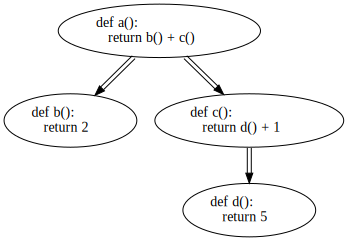

In [5]:
arrow_format = '[color="black:invis:black"]'

def render_node(n: GraphNode):
    code = '\l'.join(n.code.split('\n'))
    return f'{n.func_name} [label="{code}"]'

graph_def = '''digraph D {{   
{nodes}
    
{edges}
}}'''.format(
    nodes = '\n'.join('  ' + render_node(n) for n in g.nodes.values()),
    edges = '\n'.join(f'  {e.node1} -> {e.node2} {arrow_format}' for e in g.edges)
)

display(graphviz.Source(graph_def))

# Next Step

Wow that was easy. However the above overly simplified to help understand what are trying to achieve.

Let's do a few things

1. Create a Graph class to encapsulate the graph logic.
2. Use a decorator to transform the functions into a graph node function.
3. How about parameters? what if our function *c* was instead

```python
def c(x):
    return d() + x
```

Then surely c(1) and c(2) would be a different node in a grpah. So let's take that into account

4. Add support for overriding nodes


## Node and the key

Let's define *GNode* and *GNodeKey* to store the node and the key to the node respectively.

In [6]:
GNode = namedtuple('GNode', ['value', 'children'])
GNodeKey = namedtuple('GNodeKey', ['func', 'args', 'kwargs'])

## The Graph

We'll create a Graph class that would be responsible for

* Keeping track of nodes GNodeKey->GNode
* Support overriding nodes with a value
* Ability to invalide a node or clear the entire graph
* hand functions to get the edges

In [7]:
class Graph:
    def __init__(self):
        self.nodes: Dict[GNodeKey, GNode] = {}
        self.func_defs: Dict[str, str] = {}
        self.trace_calls = True
            
    def set_node(self, k: GNodeKey, n: GNode):
        self.nodes[k] = n
        
    def is_node(self, func_name: str):
        return func_name in self.func_defs
    
    def get_node(self, k: GNodeKey):
        return self.nodes.get(k)
    
    def clear(self):
        self.nodes = {}
    
    def add_func_def(self, func_name: str, source: str):
        self.func_defs[func_name] = source
        
    def override_value(self, func_name, val, *args, **kwargs):
        # for simplicity ignore the fact that you could
        # set value with args and kwargs

        # Override
        key = GNodeKey(func_name, args, frozendict(kwargs))
        self.set_node(key, GNode(val, []))

        # Invalidate ancesters
        ancesters = self._get_ancesters(key)
        for a in ancesters:            
            self.invalidate(a)
            
    def invalidate(self, k: GNodeKey):
        del self.nodes[k]
        
    def get_edges(self):
        return list(itertools.chain.from_iterable(
            self._get_edges_for_node(*x) for x in self.nodes.items()))
        
    def _get_edges_for_node(self, k: GNodeKey, n: GNode):
        return [(k, x) for x in n.children]
    
    def _get_ancesters(self, k: GNodeKey):
        parents = [p_k for p_k, p_n in self.nodes.items() if k in p_n.children]

        return parents + list(itertools.chain.from_iterable(self._get_ancesters(x) for x in parents))
    
graph = Graph()

## Enhanced Parser

Added logic to get the arg and kwargs for dependency. Since foo(x=1) and foo(x=2) would be 2 different nodes

In [8]:
class Parser(ast.NodeVisitor):
    def __init__(self):
        self.dependency = []

    def generic_visit(self, node):        
        if type(node).__name__ == 'Call':                        
            args = tuple(x.value for x in node.args)
            kwargs = frozendict((kw.arg, kw.value.value) for kw in node.keywords)
            self.dependency.append(GNodeKey(node.func.id, args, kwargs))
      
        ast.NodeVisitor.generic_visit(self, node)

# The Decorator

We will now create a decorator g_func that would transform the logic of the func so that it'll

1. Register itself as a node function to the graph
2. When called for the first time, cache the value on the graph
3. On subsequent calls, just get it from the cache.

In [9]:
def g_func(func):    
    p = Parser()
    source = inspect.getsource(func)
    tree = ast.parse(source)
    p.visit(tree)
    func_name = tree.body[0].name

    def f(*args, **kwargs):
        key = GNodeKey(func_name, args, frozendict(kwargs))
        cached_node = graph.get_node(key)
        if cached_node:
            return cached_node.value
        if graph.trace_calls:
            print('Calling: {}, args={}, kwargs={}'.format(func_name, args, kwargs))
            
        graph.add_func_def(func_name, source)
        value = func(*args, **kwargs)
        children = [x for x in p.dependency if graph.is_node(x.func)]
        node = GNode(value, children)
        graph.set_node(key, node)
        return value

    return f

## Functions that goes in the tree

We now define the graph functions a, b, c, d, e, and f by decorating them with g_func.

We will also define

* off_graph_func: which demonstrates that calling non-decoarted function would not create a node in the tree
* expensive_function: This function takes 1s to calculate and is used to demonstrate why a dependency gives a massive performance benefit

In [10]:
def off_graph_func():
    return 1

def expensive_function(x):
    time.sleep(1)
    return x

@g_func
def a():
    return b(x=3) + c(1) ** 2 + off_graph_func()

@g_func
def b(x=2):
    return x * x

@g_func
def c(x):
    if d() > 0:
        return x * e()
    else:
        return x * f()

@g_func
def d():
    return 5

@g_func
def e():
    return expensive_function(6)

@g_func
def f():
    return expensive_function(7)

## Node Cache

The graph.trace_call is on by default and we can see which functions are actually executed for the first time.

It also shows that it takes about a second to execute all nodes on the tree.

In [11]:
%%time

a()

Calling: a, args=(), kwargs={}
Calling: b, args=(), kwargs={'x': 3}
Calling: c, args=(1,), kwargs={}
Calling: d, args=(), kwargs={}
Calling: e, args=(), kwargs={}
CPU times: user 6.37 ms, sys: 3.34 ms, total: 9.71 ms
Wall time: 1.01 s


46

But if we call a() again, this time it returns almost instantaneously since it simply gets the result from the cache.

We can also see that there are no trace printed.

In [12]:
%%time

a()

CPU times: user 67 µs, sys: 35 µs, total: 102 µs
Wall time: 108 µs


46

## Visualising the 2nd Tree

Let's draw the tree and observe the following.

* c "could" call f() if d() <= 0. However d evaluated to 5 and so f is pruned from the tree
* It is really easy to understand the calculation with any on-graph functions. There are no debugger required.
* off-graph functions are not part of the tree (also notice that off-graph calls makes it more difficult to understand.)

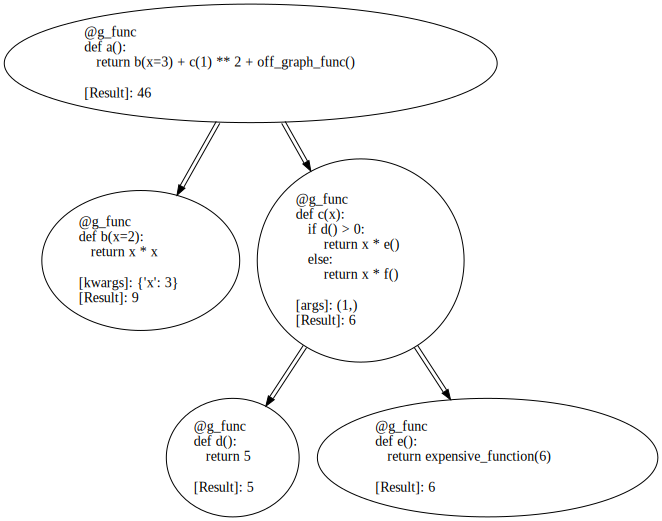

In [13]:
arrow_format = '[color="black:invis:black"]'

def render_node(k: GNodeKey, v: GNode):
    detail = '\l'.join(graph.func_defs[k.func].split('\n'))
    if k.args:
        detail += f'\l[args]: {k.args}'
       
    if k.kwargs:
        detail += f'\l[kwargs]: {dict(k.kwargs)}'

    detail += f'\l[Result]: {v.value}\l'
    return f'{hash(k)} [label="{detail}"]'

def draw_graph():
    graph_def = '''digraph D {{   
{nodes}
{edges}
}}'''.format(
        nodes = '\n'.join('  ' + render_node(*x) for x in graph.nodes.items()),
        edges = '\n'.join(f'  {hash(n1)} -> {hash(n2)} {arrow_format}' for n1, n2 in graph.get_edges())
    )

    display(graphviz.Source(graph_def))
    
draw_graph()

# Override

Now let's override c or more specifically override c(1). 

In [14]:
graph.override_value('c', 10, 1)

Since b is cached and c is overriden, only a needs to be recalculated. 

This is evidence both from the trace-call prints and the timing log.

In [15]:
%%time
a()

Calling: a, args=(), kwargs={}
CPU times: user 312 µs, sys: 162 µs, total: 474 µs
Wall time: 208 µs


110

Let's look at the graph.

We can see that a depend only on b and c which both requires no calculation.

d and e are still in the graph. If we were to later call e() it would not need to call the expensive_function to give us the result.

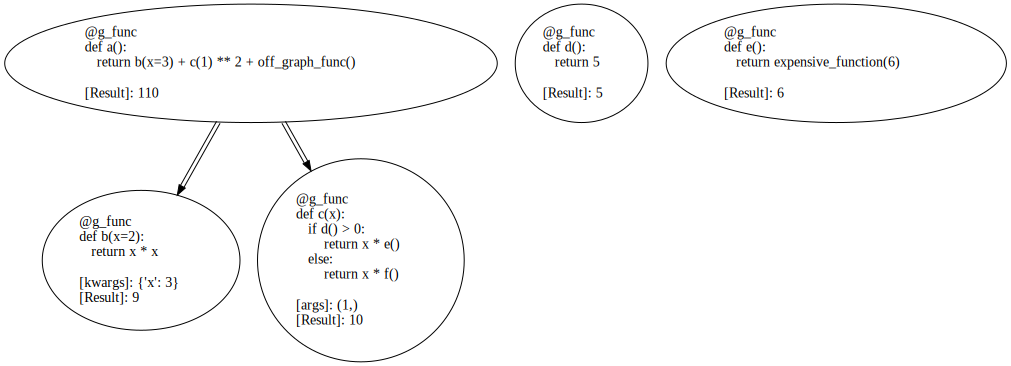

In [16]:
draw_graph()

## Same function different node

A node in the tree is defined by not only the function, but also the args and kwargs.

Let's demonstrate this by creating a new function h which call b with different kwargs. 

We would see 3 different nodes represending b. 

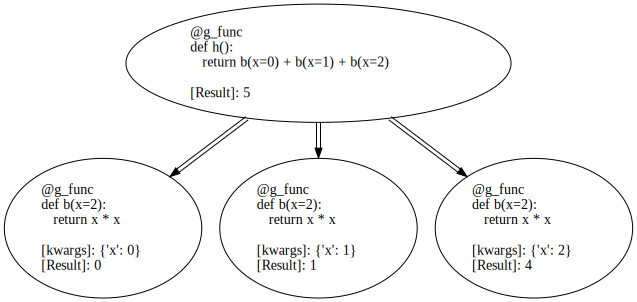

In [17]:
@g_func
def h():
    return b(x=0) + b(x=1) + b(x=2)


graph.clear()
graph.trace_calls = False
h()

draw_graph()

## Sensitivity of a on movement in c

Just to conclude this demo. Let's plot a scatter graph of a against c. 

Despite the complicated tree, only function a is executed when we generate the plot.

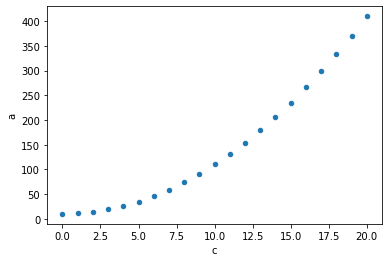

In [24]:
import pandas as pd

data = []

for val in range(21):
    graph.override_value('c', val, 1)
    data.append((val, a()))
    
pd.DataFrame(data, columns=['c', 'a']).plot.scatter('c', 'a')